# Exploration of sources of sequencing error
## AIM:
The aim of this analysis is to explore the sequence variation that occurs during very deep sequencing projects. 

The heterozygous positions that would be detected in this setup can arise from two sources:
1. Technical artefact (PCR/Library preparation/Sequencing)
2. De facto sequence variation in the culture.

## APPROACH:
We have done two things, on the one hand we used ART to generate synthetic fastq files that would simulate the errors generated by sequencing to great depths using an Illumina HiSeq 2000 machine.

> ART command

Secondly we sequenced, in duplicate, DNA from two separate colonies that were picked and expanded in 7H9. The colonies were given codes 76 and 91 and the same DNA extraction from each colony was sequeneced twice, samples K26/K27 and K28/K29 respectively. 

All these fastq files were then passed through the pipeline using the following steps

### SNP criteria:
TOOL: SAMTOOLS PILEUP

>samtools mpileup -q 30 -Q 20 -BOf \$REFERENCE \$1 > \$TMPDIR/\$BASENAME.pileup

1. Base call score >30
2. Mapping score >20

TOOL: VARSCAN

>java -jar \$VARSCAN mpileup2snp \$TMPDIR/\$BASENAME.pileup 
>    --min-coverage 50 
>    --min-reads2 4 
>    --min-avg-qual 20 
>    --min-var-freq 0.005 
>    --min-freq-for-hom 0.9 
>    --p-value 99e-02 
>    --strand-filter 1 > \$BASENAME.var

1. Minimum coverage 50
2. Minimum average quality 20
3. Minimum frequency 0.5%
4. Minimal reads 4

TOOL: Custom PERL scripts

1. Ensure 2 reads in each direction

TOOL: Custom filtering script

1. Remove SNPs in problematic regions. (all ".mixupf" files)

TOOL: Custom R script

1. Use a KS-test to ensure that variant calls do not occur due to sequence variation in the tail part of the reads. (all ".lable" files)


## DATA WRANGLING
We used the following two scripts to process the data for preliminary exploration. These SNPs are not yet annotated.

>parse_single_colony.py
>parse_ART_simulations.py

The output of these scripts are:
- 1_ART_simulation.csv
- 1_ART_simulation.pkl
- 1_colony_sequencing.csv
- 1_colony_sequencing.pkl


## ANALYSIS
Start by setting up the kernel

In [1]:
#Python core packages
from collections import Counter
import string
import pickle
import datetime
import warnings
warnings.filterwarnings("ignore")

#Additional Python packages
import tqdm

#Scientific packages
from scipy import stats as ss
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import utils as sku
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

mpl.style.use('classic')
mpl.rcParams['font.family']='Arial'
mpl.rcParams['legend.numpoints'] = 1

%matplotlib inline

In [2]:
#LOAD DATA
DF_COLONY = pd.read_csv('../data/interim/1_colony_sequencing.csv', index_col=0)
DF_ART = pd.read_csv('../data/interim/1_ART_simulation.csv', index_col=0)

## Simulation data analysis

### Generated sequencing error frequency
In the first instance we are interested in:

1. Where are the mutations?
2. What is the frequency distribution of errors,
3. how many mutations are generated by sequencing errors alone by sample, 

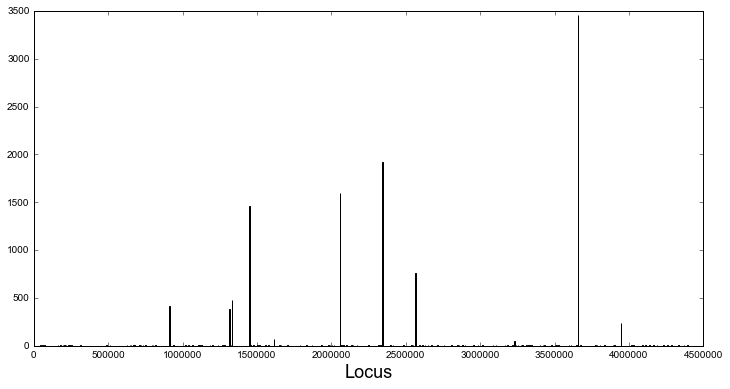

In [222]:
plt.figure(figsize=(12,6))
plt.hist(list(DF_ART[(DF_ART.STAGE=='BASIC')].LOCUS), bins=np.arange(0,4.5e6,4000), color='black')
plt.xlabel('Locus', size=18)

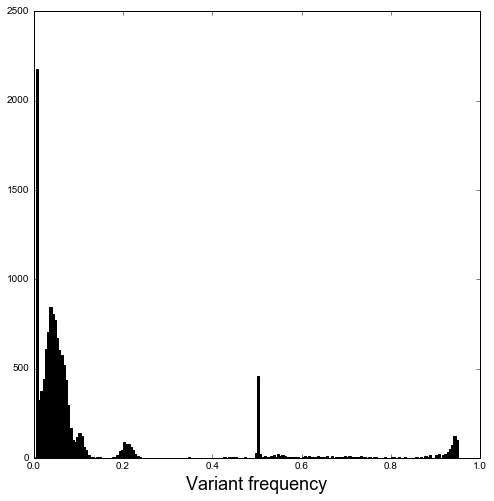

In [132]:
plt.figure(figsize=(8,8))
plt.hist(list(DF_ART[(DF_ART.STAGE=='BASIC')].FREQUENCY), bins=np.arange(0,1.005,0.005), color='black')
plt.xlabel('Variant frequency', size=18)

In [54]:
ART_SAMPLES = list(set(DF_ART.SIMULATION))
ART_VARIANT_COUNTS = {x: {'BASIC':0, 'FILTER': 0, 'FINAL': 0} for x in ART_SAMPLES}
for stage in ['BASIC', 'FILTER', 'FINAL']:
    VAR_COUNT = Counter(list(DF_ART[(DF_ART.STAGE==stage)].SIMULATION))
    for sample in ART_SAMPLES:
        try:
            ART_VARIANT_COUNTS[sample][stage]+=VAR_COUNT[sample]
        except:
            pass

DF_ART_COUNTS = pd.DataFrame(ART_VARIANT_COUNTS).T

(0, 40)

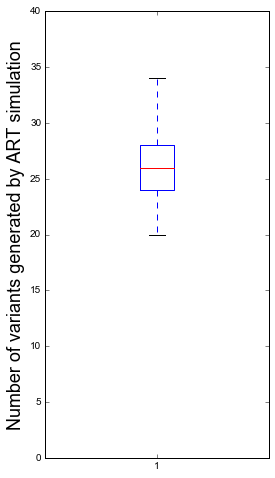

In [133]:
plt.figure(figsize=(4,8))
plt.boxplot(DF_ART_COUNTS.BASIC)
plt.ylabel('Number of variants generated by ART simulation', size=18)
plt.ylim(0,40)

We ran 500 simulations at an expected average depth of 1000. Each simulation generates about 25 variant SNP calls and leads to a multimodal distribution of frequencies with a peak between 0.5-1.0% and a considerable bulk of frequencies around 5%.

Is there any correlation between frequency and coverage?

(0, 1)

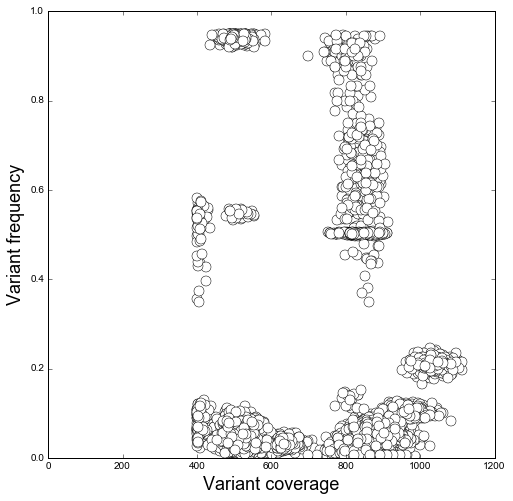

In [134]:
plt.figure(figsize=(8,8))
plt.plot(list(DF_ART[(DF_ART.STAGE=='BASIC')].COVERAGE), 
         list(DF_ART[(DF_ART.STAGE=='BASIC')].FREQUENCY), 
         'o', mfc='white', mec='black', ms=10)
plt.ylabel('Variant frequency', size=18)
plt.xlabel('Variant coverage', size=18)
plt.xlim(0,1200)
plt.ylim(0,1)

Fair to say there isn't an obvious relationship. But this is a very random distribution of coverages... what does it actually look like???

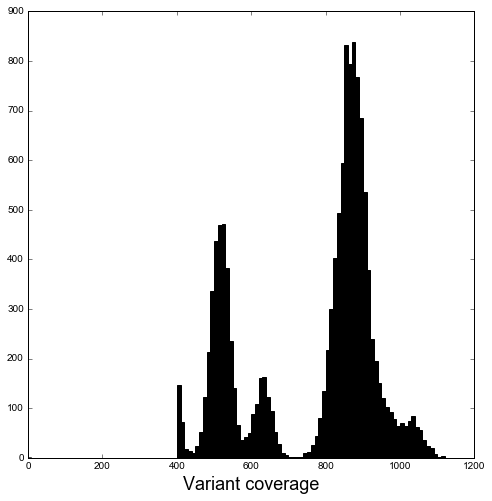

In [135]:
plt.figure(figsize=(8,8))
plt.hist(list(DF_ART[(DF_ART.STAGE=='BASIC')].COVERAGE), bins=np.arange(0,1200,10), color='black')
plt.xlabel('Variant coverage', size=18)

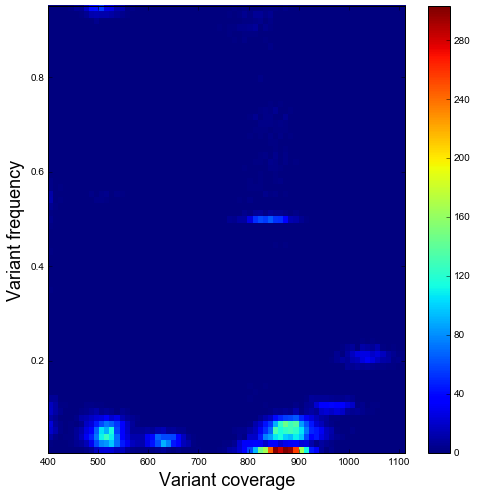

In [136]:
plt.figure(figsize=(8,8))
plt.hist2d(list(DF_ART[(DF_ART.STAGE=='BASIC')].COVERAGE),
           list(DF_ART[(DF_ART.STAGE=='BASIC')].FREQUENCY), 70)
plt.ylabel('Variant frequency', size=18)
plt.xlabel('Variant coverage', size=18)
plt.colorbar()

Looking at raw outputs, there is a clear concentration of reads where I'd expect them (0.5-1.0% frequency around coverage of 880), but there are quite a few with half the coverage (500) and an 'echo' of the main group that progresses I would potentially expect it to (thought too fast) as the coverage increases... I wonder weather or not these are mapping artefacts arising from repetitive regions. If true, filtering out the problematic regions through exclusion should improve things.

### Impact of pipeline filtering

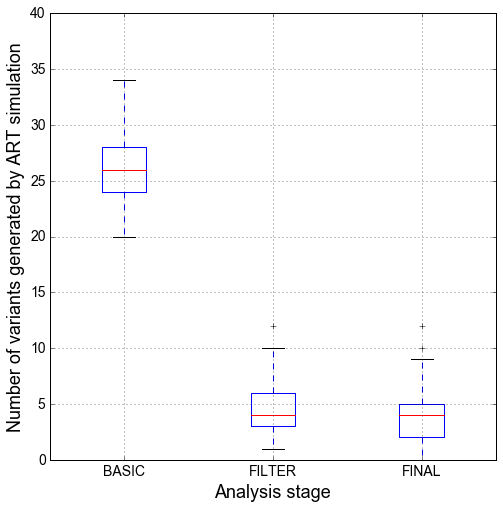

In [56]:
plt.figure(figsize=(8,8))
DF_ART_COUNTS.boxplot()
plt.ylabel('Number of variants generated by ART simulation', size=18)
plt.xlabel('Analysis stage', size=18)
plt.ylim(0,40)
plt.xticks(size=14)
plt.yticks(size=14)

#NOW = datetime.datetime.now()
#TARGET = '../reports/figures/{}_vSNP_count_ART_simulations.pdf'.format(NOW.strftime('%y%m%d'))
#plt.savefig(TARGET)

(0, 20)

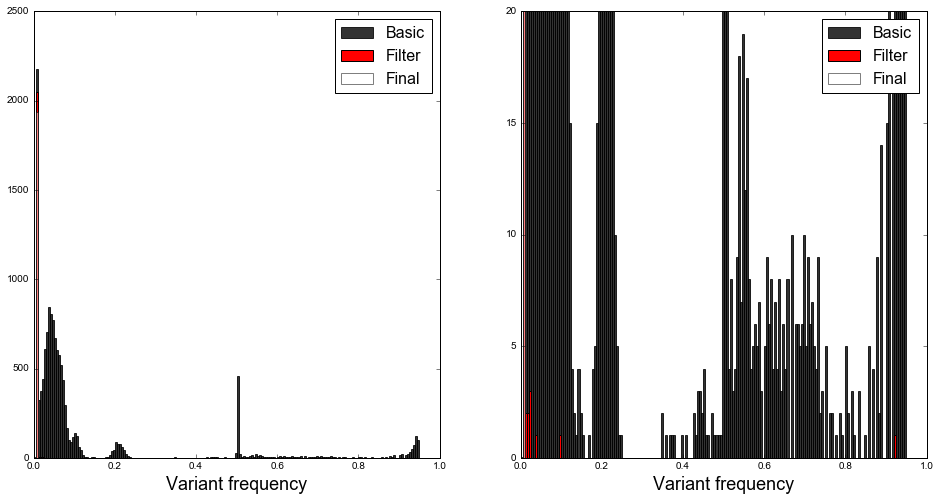

In [138]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.hist(list(DF_ART[(DF_ART.STAGE=='BASIC')].FREQUENCY), 
         bins=np.arange(0,1.005,0.005), color='black', 
         label='Basic', alpha=0.8)
plt.hist(list(DF_ART[(DF_ART.STAGE=='FILTER')].FREQUENCY), 
         bins=np.arange(0,1.005,0.005), color='red', 
         label='Filter')
plt.hist(list(DF_ART[(DF_ART.STAGE=='FINAL')].FREQUENCY),
         bins=np.arange(0,1.005,0.005), color='white', 
         label='Final', alpha=0.5)
plt.legend(fontsize=16)
plt.xlabel('Variant frequency', size=18)
plt.subplot(122)
plt.hist(list(DF_ART[(DF_ART.STAGE=='BASIC')].FREQUENCY), 
         bins=np.arange(0,1.005,0.005), color='black', 
         label='Basic', alpha=0.8)
plt.hist(list(DF_ART[(DF_ART.STAGE=='FILTER')].FREQUENCY), 
         bins=np.arange(0,1.005,0.005), color='red', 
         label='Filter')
plt.hist(list(DF_ART[(DF_ART.STAGE=='FINAL')].FREQUENCY),
         bins=np.arange(0,1.005,0.005), color='white', 
         label='Final', alpha=0.5)
plt.legend(fontsize=16)
plt.xlabel('Variant frequency', size=18)
plt.ylim(0,20)

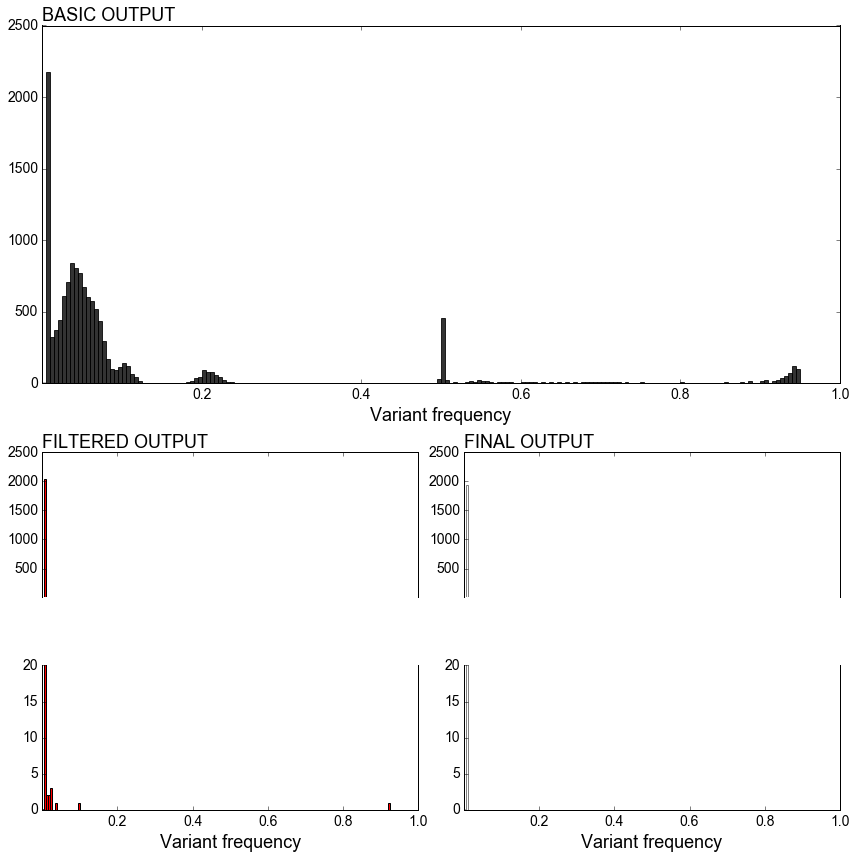

In [52]:
plt.figure(figsize=(12,12))
plt.subplot2grid((4,4),(0,0),rowspan=2,colspan=4)
plt.hist(list(DF_ART[(DF_ART.STAGE=='BASIC')].FREQUENCY), 
         bins=np.arange(0,1.005,0.005), color='black', 
         label='Basic', alpha=0.8)
plt.xticks(np.arange(0.2,1.2,.2),size=14)
plt.xlabel('Variant frequency', size=18)
plt.yticks(size=14)
plt.title('BASIC OUTPUT', loc='left', size=18)

ax = plt.subplot2grid((4,4),(2,0),rowspan=1,colspan=2)
plt.title('FILTERED OUTPUT', loc='left', size=18)
plt.hist(list(DF_ART[(DF_ART.STAGE=='FILTER')].FREQUENCY), 
         bins=np.arange(0,1.005,0.005), color='red', 
         label='Filter')
plt.ylim(20,2500)
plt.xticks(np.arange(0,1.2,.2),[],size=14)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('top')
plt.yticks(size=14)

ax=plt.subplot2grid((4,4),(3,0),rowspan=1,colspan=2)
plt.hist(list(DF_ART[(DF_ART.STAGE=='FILTER')].FREQUENCY), 
         bins=np.arange(0,1.005,0.005), color='red', 
         label='Filter')
plt.ylim(0,20)
plt.xlabel('Variant frequency', size=18)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xticks(np.arange(0.2,1.2,.2),size=14)
plt.yticks(size=14)

ax = plt.subplot2grid((4,4),(2,2),rowspan=1,colspan=2)
plt.title('FINAL OUTPUT', loc='left', size=18)
plt.hist(list(DF_ART[(DF_ART.STAGE=='FINAL')].FREQUENCY),
         bins=np.arange(0,1.005,0.005), color='white', 
         label='Final', alpha=0.5)
plt.xticks(np.arange(0.2,1.2,.2),[],size=14)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('top')
plt.yticks(size=14)
plt.ylim(20,2500)

ax = plt.subplot2grid((4,4),(3,2),rowspan=1,colspan=2)
plt.hist(list(DF_ART[(DF_ART.STAGE=='FINAL')].FREQUENCY),
         bins=np.arange(0,1.005,0.005), color='white', 
         label='Final', alpha=0.5)
plt.ylim(0,20)
plt.xlabel('Variant frequency', size=18)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xticks(np.arange(0.2,1.2,.2),size=14)
plt.yticks(size=14)

plt.tight_layout()

#NOW = datetime.datetime.now()
#TARGET = '../reports/figures/{}_SFS_ART_simulations.pdf'.format(NOW.strftime('%y%m%d'))
#plt.savefig(TARGET)

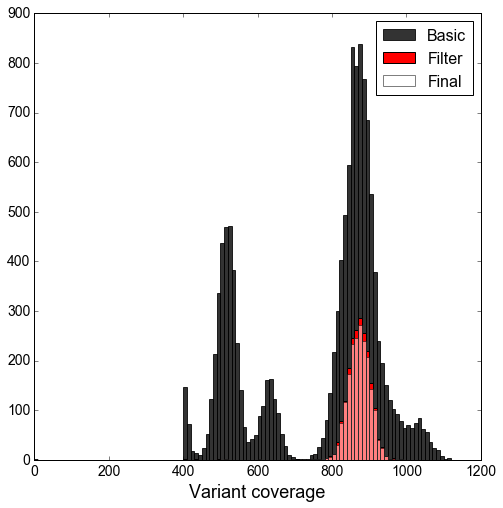

In [57]:
plt.figure(figsize=(8,8))
plt.hist(list(DF_ART[(DF_ART.STAGE=='BASIC')].COVERAGE), 
         bins=np.arange(0,1200,10), color='black', 
         label='Basic', alpha=0.8)
plt.hist(list(DF_ART[(DF_ART.STAGE=='FILTER')].COVERAGE), 
         bins=np.arange(0,1200,10), color='red', 
         label='Filter')
plt.hist(list(DF_ART[(DF_ART.STAGE=='FINAL')].COVERAGE),
         bins=np.arange(0,1200,10), color='white', 
         label='Final', alpha=0.5)
plt.legend(fontsize=16)
plt.xlabel('Variant coverage', size=18)
plt.xticks(size=14)
plt.yticks(size=14)

#NOW = datetime.datetime.now()
#TARGET = '../reports/figures/{}_coverage_ART_simulations.pdf'.format(NOW.strftime('%y%m%d'))
#plt.savefig(TARGET)

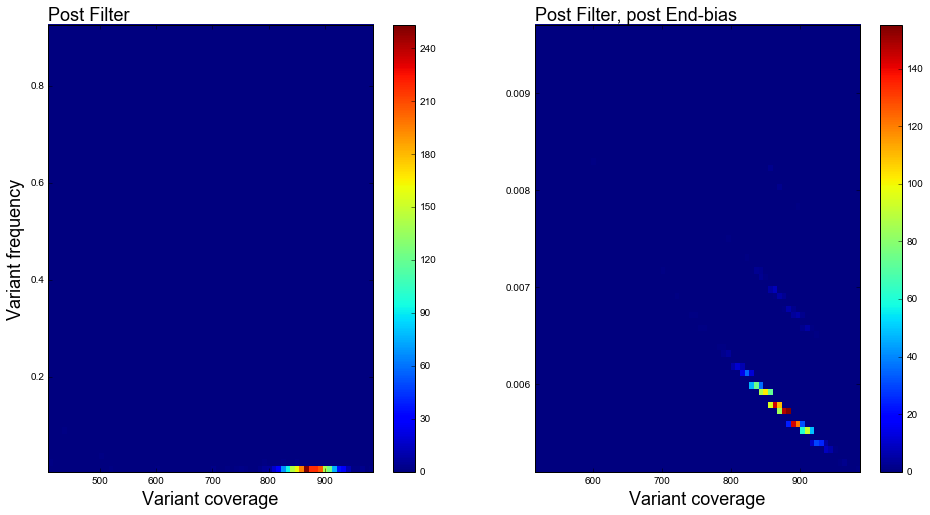

In [140]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.hist2d(list(DF_ART[(DF_ART.STAGE=='FILTER')].COVERAGE),
           list(DF_ART[(DF_ART.STAGE=='FILTER')].FREQUENCY), 70)
plt.ylabel('Variant frequency', size=18)
plt.xlabel('Variant coverage', size=18)
plt.title('Post Filter', loc='left', size=18)
plt.colorbar()
plt.subplot(122)
plt.hist2d(list(DF_ART[(DF_ART.STAGE=='FINAL')].COVERAGE),
           list(DF_ART[(DF_ART.STAGE=='FINAL')].FREQUENCY), 70)
plt.xlabel('Variant coverage', size=18)
plt.title('Post Filter, post End-bias', loc='left', size=18)
plt.colorbar()

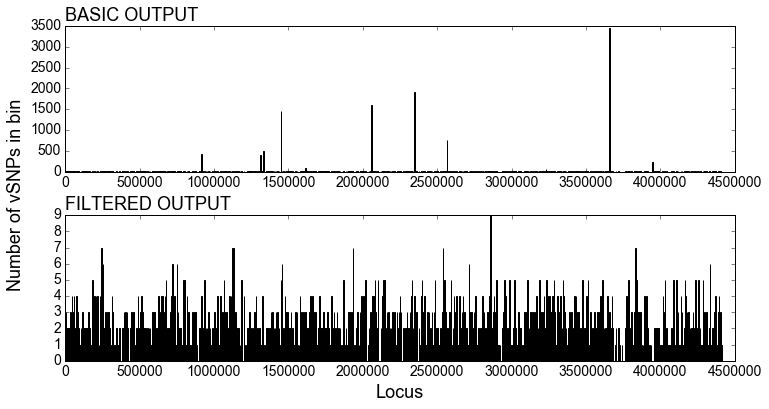

In [73]:
plt.figure(figsize=(12,6))
plt.subplot(211)
plt.hist(list(DF_ART[(DF_ART.STAGE=='BASIC')].LOCUS), bins=np.arange(0,4.5e6,4000), color='black')
plt.ylabel('Number of vSNPs in bin', size=18, horizontalalignment='right')
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('BASIC OUTPUT', loc='left', size=18)
plt.subplot(212)
plt.title('FILTERED OUTPUT', loc='left', size=18)
plt.hist(list(DF_ART[(DF_ART.STAGE=='FINAL')].LOCUS), bins=np.arange(0,4.5e6,4000), color='black')
plt.xlabel('Locus', size=18)
plt.xticks(size=14)
plt.yticks(size=14)

plt.subplots_adjust(hspace=0.3)

#NOW = datetime.datetime.now()
#TARGET = '../reports/figures/{}_locus_ART_simulations.pdf'.format(NOW.strftime('%y%m%d'))
#plt.savefig(TARGET)

Filtering works. Very well. It fixes:

1. Coverage issues,
2. Most spurious higher frequency variable calls,
3. High number of variant calls,
4. Genomic jackpotting.

The mapping of PE/PPEs, integrases, amylases etc. is clearly problematic and excluding them from downstream analysis clearly deals with many mapping issues. Remember that this dataset was generated by mapping CCDC5079 generated fastq onto H37Rv, therefore differences in coverage will clearly result from genomic deletions/duplications which often affect mobile elements... 

Polishing the data using read-end bias exclusion adds little when compared to genomic region filtering, however it does seem to catch additional spurious variant calls. We are then still left with a bunch of variants, but an empirical threshold should get rid of all of these. <strong>Try 1%.</strong>

### Ulterior filters

(0, 0.02)

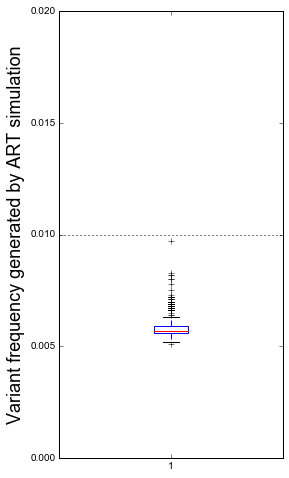

In [141]:
plt.figure(figsize=(4,8))
plt.boxplot(DF_ART[DF_ART.STAGE=='FINAL'].FREQUENCY)
plt.ylabel('Variant frequency generated by ART simulation', size=18)
plt.hlines(0.01,0,2, linestyles='dotted')
plt.ylim(0,0.02)

<strong>1% works.</strong>

It is interesting to see the downward slope in the 2D histogram of the final output. This almost seems to suggest that there is a more or less fixed number of congruent errors that occurs in each direction (we must be close to the edge of the error distribution here) that results in a <em>de facto</em> decreasing relationship between frequency and coverage. 

In [122]:
DF_ART['LOG_FREQUENCY'] = [np.log(x) for x in DF_ART.FREQUENCY]
model = sm.OLS.from_formula('LOG_FREQUENCY ~ COVERAGE', DF_ART[DF_ART.STAGE=='FINAL'])
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          LOG_FREQUENCY   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     1831.
Date:                Tue, 09 Aug 2016   Prob (F-statistic):          5.02e-282
Time:                        12:23:21   Log-Likelihood:                 3640.8
No. Observations:                1936   AIC:                            -7278.
Df Residuals:                    1934   BIC:                            -7267.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -4.1276      0.024   -172.098      0.0

In [123]:
result.params[1]

-0.0011769655125605781

(0.005, 0.02)

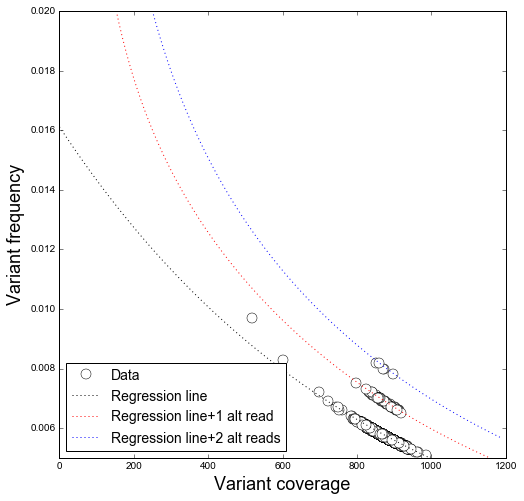

In [127]:
plt.figure(figsize=(8,8))
plt.plot(list(DF_ART[(DF_ART.STAGE=='FINAL')].COVERAGE), 
         list(DF_ART[(DF_ART.STAGE=='FINAL')].FREQUENCY), 
         'o', mfc='white', mec='black', ms=10, label='Data')

plt.plot(np.arange(0,1200,10), 
         np.exp(np.arange(0,1200,10)*result.params[1]+result.params[0]), 
         'k:', label='Regression line')

plt.plot(np.arange(0,1200,10), 
         np.exp(np.arange(0,1200,10)*result.params[1]+result.params[0])+(1/np.arange(0,1200,10)), 
         'r:', label='Regression line+1 alt read')

plt.plot(np.arange(0,1200,10), 
         np.exp(np.arange(0,1200,10)*result.params[1]+result.params[0])+(2/np.arange(0,1200,10)), 
         'b:', label='Regression line+2 alt reads')

plt.legend(loc=3, fontsize=14)
plt.ylabel('Variant frequency', size=18)
plt.xlabel('Variant coverage', size=18)
plt.xlim(0,1200)
#plt.yscale('log')
plt.ylim(0.005,0.02)

This is a bit messy, but it seems that we're on the right track. Just for the fun of it plot what this would look like for a fixed number of alternative base calls...

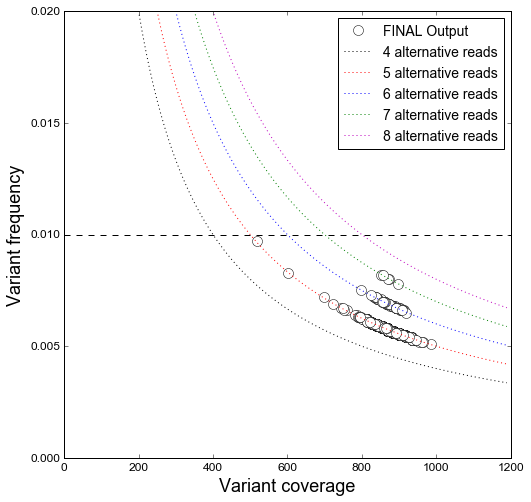

In [14]:
plt.figure(figsize=(8,8))
plt.plot(list(DF_ART[(DF_ART.STAGE=='FINAL')].COVERAGE), 
         list(DF_ART[(DF_ART.STAGE=='FINAL')].FREQUENCY), 
         'o', mfc='white', mec='black', ms=10, label='FINAL Output')

plt.plot(np.arange(0,1200,10), 
         4/np.arange(0,1200,10), 
         'k:', label='4 alternative reads')

plt.plot(np.arange(0,1200,10), 
         5/np.arange(0,1200,10), 
         'r:', label='5 alternative reads')

plt.plot(np.arange(0,1200,10), 
         6/np.arange(0,1200,10), 
         'b:', label='6 alternative reads')

plt.plot(np.arange(0,1200,10), 
         7/np.arange(0,1200,10), 
         'g:', label='7 alternative reads')

plt.plot(np.arange(0,1200,10), 
         8/np.arange(0,1200,10), 
         'm:', label='8 alternative reads')

plt.legend(loc=0, fontsize=14)
plt.ylabel('Variant frequency', size=18)
plt.xlabel('Variant coverage', size=18)
plt.xlim(0,1200)
#plt.yscale('log')
plt.ylim(0,0.02)
plt.hlines(0.01,0,1200, linestyles='dashed')
plt.yticks(size=12)
plt.xticks(size=12)

#plt.savefig('../reports/figures/1_ART_FreqCov.pdf')
#plt.savefig('../reports/figures/1_ART_FreqCov.png',dpi=300)

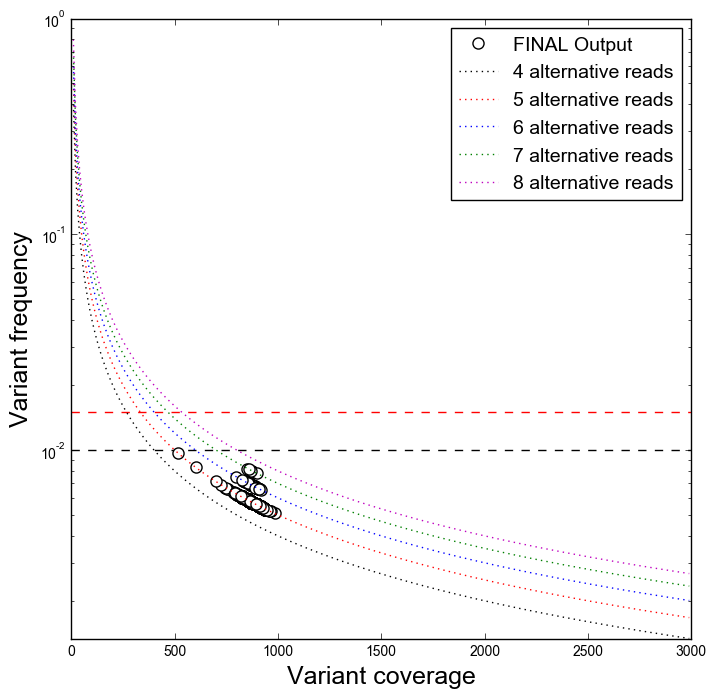

In [15]:
tick_size = 10
label_size = 18
title_size = 12
text_size = 14

plt.figure(figsize=(8,8))
plt.plot(list(DF_ART[(DF_ART.STAGE=='FINAL')].COVERAGE), 
         list(DF_ART[(DF_ART.STAGE=='FINAL')].FREQUENCY), 
         'o', mfc='white', mec='black', mew=1, ms=8, label='FINAL Output')

plt.plot(np.arange(0,3000,10), 
         4/np.arange(0,3000,10), 
         'k:', label='4 alternative reads')

plt.plot(np.arange(0,3000,10), 
         5/np.arange(0,3000,10), 
         'r:', label='5 alternative reads')

plt.plot(np.arange(0,3000,10), 
         6/np.arange(0,3000,10), 
         'b:', label='6 alternative reads')

plt.plot(np.arange(0,3000,10), 
         7/np.arange(0,3000,10), 
         'g:', label='7 alternative reads')

plt.plot(np.arange(0,3000,10), 
         8/np.arange(0,3000,10), 
         'm:', label='8 alternative reads')

plt.legend(loc=0, fontsize=text_size)
plt.ylabel('Variant frequency', size=label_size)
plt.xlabel('Variant coverage', size=label_size)
plt.xlim(0,3000)
plt.yscale('log')
plt.ylim(0,1)
plt.hlines(0.01,0,3000, linestyles='dashed')
plt.hlines(0.015,0,3000, linestyles='dashed', colors='red')
plt.yticks(size=tick_size)
plt.xticks(size=tick_size)


plt.savefig('../reports/figures/1_ART_FreqCov.pdf')
plt.savefig('../reports/figures/1_ART_FreqCov.png',dpi=300)

This behaves as expected, given that the assumption of a fixed number of mutations describes the pattern much better than regression can... At coverages < 800 you only ever see examples of 5 alternative base calls, around 800 you see 6 appearing and then around 900 you see 7 appearing. incidentally there is also an increase in the density of data at lower alternative reads indicating the underlying probabilty mass function of the simulation algorithm.

The question then is: <strong>should this be filtered at the point of frequency or read number?</strong>

To be honest, given how we calculate frequency it really makes little difference. But it does seem like a good idea to drop any vSNP that falls on one of the trivial contour lines?

So based on this:
1. The pipeline does a good job of trimming most of the noise (that most probably arises from mapping isssues?)
2. Set a frequency threshold of 1% _OR_
3. Increase the read count filter to 3-3-8 / 4-4

## Single colony re-sequencing

Start with the SFS of the basic data

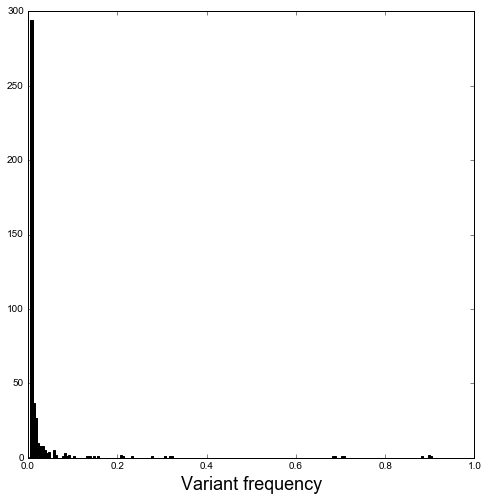

In [142]:
plt.figure(figsize=(8,8))
plt.hist(list(DF_COLONY[(DF_COLONY.STAGE=='BASIC')].FREQUENCY), bins=np.arange(0,1.005,0.005), color='black')
plt.xlabel('Variant frequency', size=18)

This looks a lot like patient data... what about the 2D histogram?

(0, 1)

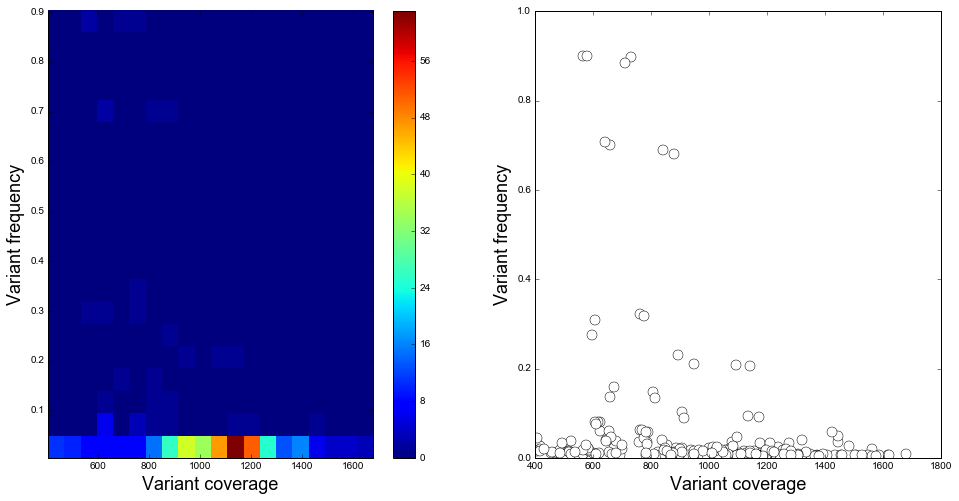

In [147]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.hist2d(list(DF_COLONY[(DF_COLONY.STAGE=='BASIC')].COVERAGE),
           list(DF_COLONY[(DF_COLONY.STAGE=='BASIC')].FREQUENCY), 20)
plt.ylabel('Variant frequency', size=18)
plt.xlabel('Variant coverage', size=18)
plt.colorbar()
plt.subplot(122)
plt.plot(list(DF_COLONY[(DF_COLONY.STAGE=='BASIC')].COVERAGE),
           list(DF_COLONY[(DF_COLONY.STAGE=='BASIC')].FREQUENCY), 
           'o', mfc='white', mec='black', ms=10)
plt.ylabel('Variant frequency', size=18)
plt.xlabel('Variant coverage', size=18)
plt.xlim(400,1800)
plt.ylim(0,1)

Less extreme than the simulation data, but seems to show similar patterns. Let's see what happens with applying the pipeline.

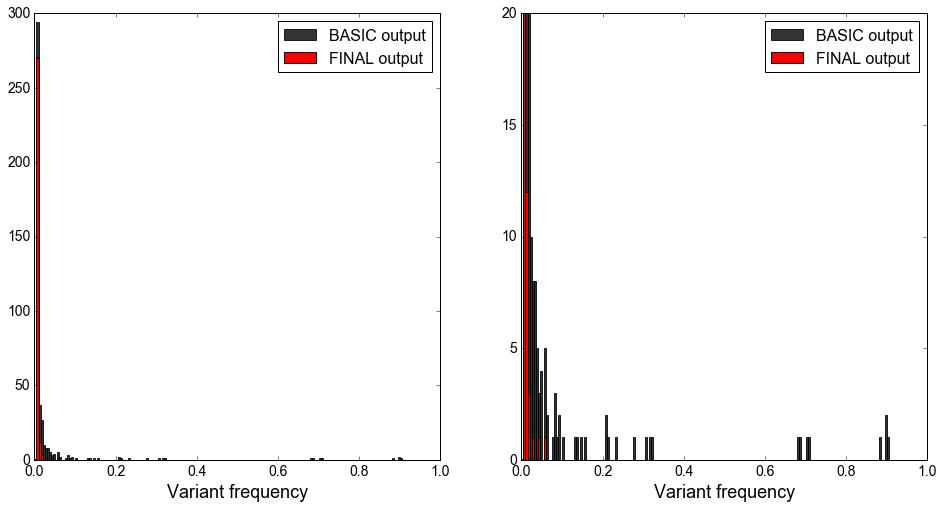

In [91]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.hist(list(DF_COLONY[(DF_COLONY.STAGE=='BASIC')].FREQUENCY), 
         bins=np.arange(0,1.005,0.005), color='black', 
         label='BASIC output', alpha=0.8)
plt.hist(list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')].FREQUENCY),
         bins=np.arange(0,1.005,0.005), color='red', 
         label='FINAL output')
plt.legend(fontsize=16)
plt.xlabel('Variant frequency', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.subplot(122)
plt.hist(list(DF_COLONY[(DF_COLONY.STAGE=='BASIC')].FREQUENCY), 
         bins=np.arange(0,1.005,0.005), color='black', 
         label='BASIC output', alpha=0.8)
plt.hist(list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')].FREQUENCY),
         bins=np.arange(0,1.005,0.005), color='red', 
         label='FINAL output')
plt.legend(fontsize=16)
plt.xlabel('Variant frequency', size=18)
plt.ylim(0,20)
plt.xticks(size=14)
plt.yticks(size=14)

#NOW = datetime.datetime.now()
#TARGET = '../reports/figures/{}_colony_SFS.pdf'.format(NOW.strftime('%y%m%d'))
#plt.savefig(TARGET)

(0, 1)

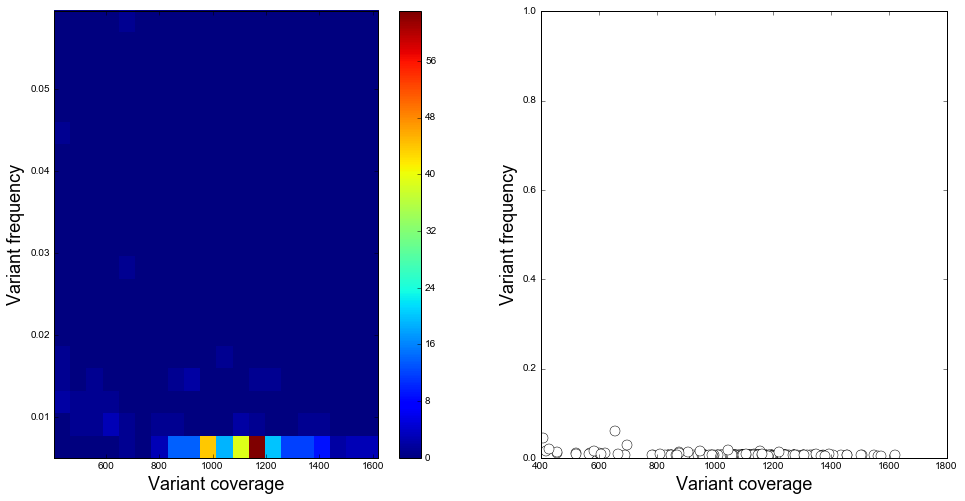

In [150]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.hist2d(list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')].COVERAGE),
           list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')].FREQUENCY), 20)
plt.ylabel('Variant frequency', size=18)
plt.xlabel('Variant coverage', size=18)
plt.colorbar()
plt.subplot(122)
plt.plot(list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')].COVERAGE),
           list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')].FREQUENCY), 
           'o', mfc='white', mec='black', ms=10)
plt.ylabel('Variant frequency', size=18)
plt.xlabel('Variant coverage', size=18)
plt.xlim(400,1800)
plt.ylim(0,1)

Same as before, this seems to work... how about the genomic distribution of mutations?

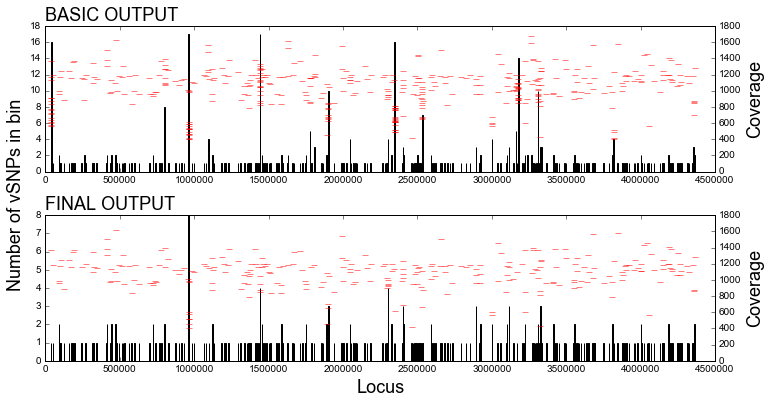

In [78]:
plt.figure(figsize=(12,6))
plt.subplot(211)
plt.title('BASIC OUTPUT', loc='left', size=18)
plt.hist(list(DF_COLONY[(DF_COLONY.STAGE=='BASIC')].LOCUS), bins=np.arange(0,4.5e6,4000), color='black')
plt.ylabel('Number of vSNPs in bin', size=18, horizontalalignment='right')
plt.twinx()
plt.plot(list(DF_COLONY[(DF_COLONY.STAGE=='BASIC')].LOCUS), 
         list(DF_COLONY[(DF_COLONY.STAGE=='BASIC')].COVERAGE), 'r_')
plt.ylim(0,1800)
plt.ylabel('Coverage', size=18)
plt.subplot(212)
plt.title('FINAL OUTPUT', loc='left', size=18)
plt.hist(list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')].LOCUS), bins=np.arange(0,4.5e6,4000), color='black')
plt.xlabel('Locus', size=18)
plt.twinx()
plt.plot(list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')].LOCUS), 
         list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')].COVERAGE), 'r_')
plt.ylim(0,1800)
plt.ylabel('Coverage', size=18)

plt.subplots_adjust(hspace=0.3)

#NOW = datetime.datetime.now()
#TARGET = '../reports/figures/{}_locus_colony.pdf'.format(NOW.strftime('%y%m%d'))
#plt.savefig(TARGET)

There are still spots that are not dealt with...

As a reality check, compare the problematic regions between single colonies and the ART output...

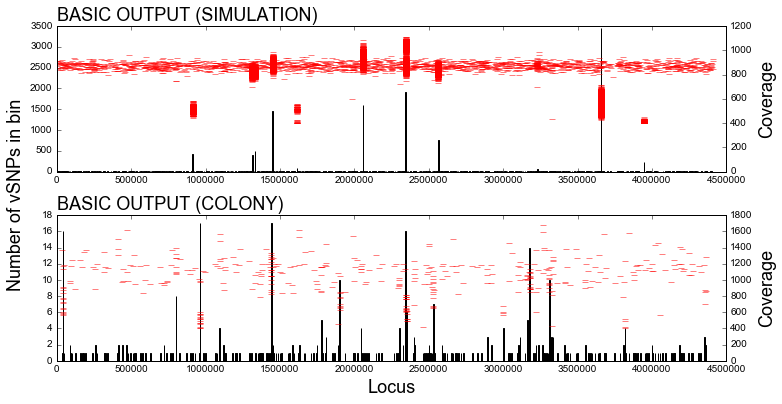

In [79]:
plt.figure(figsize=(12,6))
plt.subplot(211)
plt.title('BASIC OUTPUT (SIMULATION)', loc='left', size=18)
plt.hist(list(DF_ART[(DF_ART.STAGE=='BASIC')].LOCUS), bins=np.arange(0,4.5e6,4000), color='black')
plt.ylabel('Number of vSNPs in bin', size=18, horizontalalignment='right')
plt.twinx()
plt.plot(list(DF_ART[(DF_ART.STAGE=='BASIC')].LOCUS), 
         list(DF_ART[(DF_ART.STAGE=='BASIC')].COVERAGE), 'r_')
plt.ylim(0,1200)
plt.ylabel('Coverage', size=18)
plt.subplot(212)
plt.title('BASIC OUTPUT (COLONY)', loc='left', size=18)
plt.hist(list(DF_COLONY[(DF_COLONY.STAGE=='BASIC')].LOCUS), bins=np.arange(0,4.5e6,4000), color='black')
plt.xlabel('Locus', size=18)
plt.twinx()
plt.plot(list(DF_COLONY[(DF_COLONY.STAGE=='BASIC')].LOCUS), 
         list(DF_COLONY[(DF_COLONY.STAGE=='BASIC')].COVERAGE), 'r_')
plt.ylim(0,1800)
plt.ylabel('Coverage', size=18)

plt.subplots_adjust(hspace=0.3)

#NOW = datetime.datetime.now()
#TARGET = '../reports/figures/{}_locus_comparison.pdf'.format(NOW.strftime('%y%m%d'))
#plt.savefig(TARGET)

In [227]:
DF_COLONY[(DF_COLONY.LOCUS>9e5)&(DF_COLONY.LOCUS<1e6)]

,ALT_BASE,COLONY,COVERAGE,FREQUENCY,LOCUS,REF_BASE,STAGE
18,T,76-K26,1127,0.0053,912307,G,FINAL
19,A,76-K26,1147,0.0052,931609,C,FINAL
20,T,76-K26,1106,0.0063,984111,G,FINAL
141,T,76-K26,1127,0.0053,912307,G,BASIC
142,A,76-K26,1147,0.0052,931609,C,BASIC
143,G,76-K26,466,0.0107,963481,A,BASIC
144,C,76-K26,466,0.0107,963504,G,BASIC
145,G,76-K26,408,0.0294,963506,C,BASIC
146,T,76-K26,1106,0.0063,984111,G,BASIC
290,A,76-K27,1008,0.0069,959256,C,FINAL


Seems that 963XXX is a problematic region (low coverage). What does the coverage look like before and after filtering?

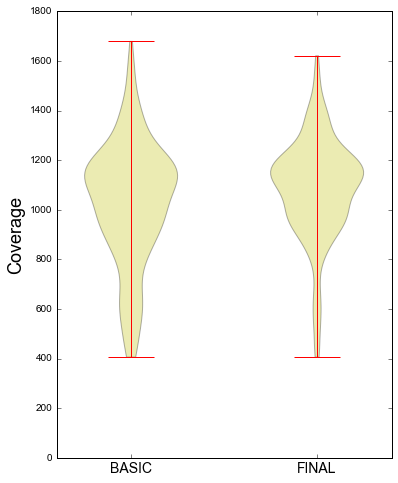

In [87]:
plt.figure(figsize=(6,8))
plt.violinplot([DF_COLONY.COVERAGE[DF_COLONY.STAGE=='BASIC'],DF_COLONY.COVERAGE[DF_COLONY.STAGE=='FINAL']])
plt.ylabel('Coverage', size=18)
plt.ylim(0,1800)
plt.xticks([1,2], ['BASIC', 'FINAL'], size=14)

#NOW = datetime.datetime.now()
#TARGET = '../reports/figures/{}_colony_violin.pdf'.format(NOW.strftime('%y%m%d'))
#plt.savefig(TARGET)

I wonder if there is a correlation between variation-rich regions and coverage. Seems to be aparent from variable loci... The violin plot shows a tailing off of variable positions for the FINAL SNPs around a coverage of 800. The max on the other side seems to suggest a mean around 1100. So let's bin up the genome and call loci as problematic or not.

In [3]:
h,b = np.histogram(DF_COLONY.LOCUS[(DF_COLONY.STAGE=='BASIC')], bins=np.arange(0,4.4e6,4000))
intervals_care = b[h>3]

DF_COLONY['HIGH_VARIATION'] = [int(sum([int(x>-4000 and x<1) for x in intervals_care-_locus])>0) for _locus in DF_COLONY.LOCUS]

In [18]:
model_all = sm.Logit.from_formula('HIGH_VARIATION ~ COVERAGE', DF_COLONY[DF_COLONY.STAGE=='BASIC'])
result_all = model_all.fit()
print(result_all.summary())

Optimization terminated successfully.
         Current function value: 0.524763
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         HIGH_VARIATION   No. Observations:                  431
Model:                          Logit   Df Residuals:                      429
Method:                           MLE   Df Model:                            1
Date:                Wed, 10 Aug 2016   Pseudo R-squ.:                  0.1983
Time:                        12:25:49   Log-Likelihood:                -226.17
converged:                       True   LL-Null:                       -282.10
                                        LLR p-value:                 3.833e-26
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      4.5239      0.584      7.749      0.000         3.380     5.668
COVERAGE      -0.0051      0.

In [4]:
model = sm.Logit.from_formula('HIGH_VARIATION ~ COVERAGE', DF_COLONY[DF_COLONY.STAGE=='FINAL'])
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.270870
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         HIGH_VARIATION   No. Observations:                  288
Model:                          Logit   Df Residuals:                      286
Method:                           MLE   Df Model:                            1
Date:                Wed, 10 Aug 2016   Pseudo R-squ.:                  0.1894
Time:                        11:35:59   Log-Likelihood:                -78.011
converged:                       True   LL-Null:                       -96.233
                                        LLR p-value:                 1.570e-09
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      3.2471      0.933      3.480      0.001         1.418     5.076
COVERAGE      -0.0054      0.

What does this mean? Based on the parameters the probabilty of being in a HIGH_VARIATION region if there is a coverage of 0 is 96.3%:

log-odds = 3.2471

odds ratio = $e^{3.2471}$ = 25.7

p = $\frac{e^{3.2471}}{1+e^{3.2471}}$ = $\frac{25.7}{1+25.7}$ = 0.963

Let's see how the probability of being a HIGH_VARIATION SNP changes with coverage

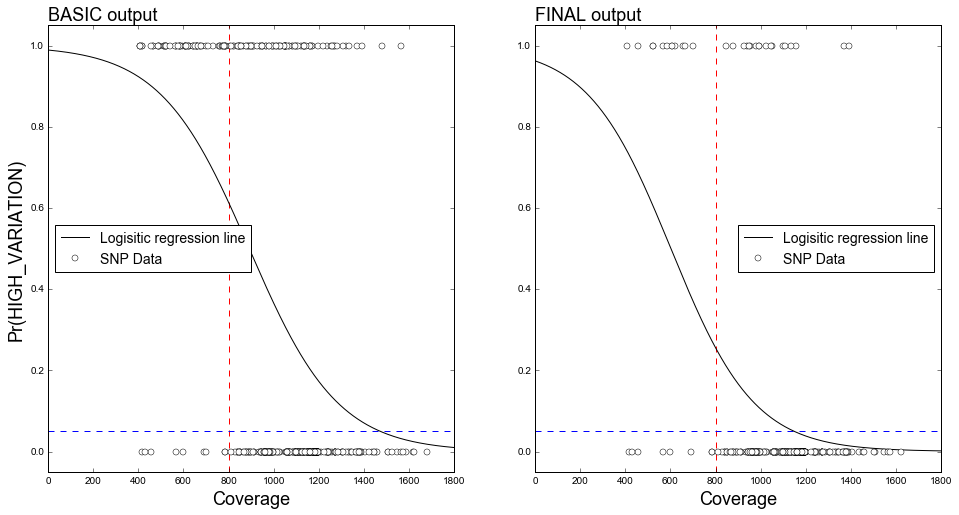

In [81]:
I , B1 = result.params
I_all, B1_all = result_all.params

#Calculate the log-odds of being HV at each coverage
LOGODDS = np.arange(1800)*B1+I
LOGODDS_all = np.arange(1800)*B1_all+I_all
#Calculate ODDS
ODDS = np.exp(LOGODDS)
ODDS_all = np.exp(LOGODDS_all)
#Calculate Probability
P = ODDS/(1+ODDS)
P_all = ODDS_all/(1+ODDS_all)

plt.figure(figsize=(16,8))

plt.subplot(121)
plt.plot(np.arange(1800),P_all,'k-')
plt.plot(DF_COLONY[DF_COLONY.STAGE=='BASIC'].COVERAGE, DF_COLONY[DF_COLONY.STAGE=='BASIC'].HIGH_VARIATION, 'wo')
plt.xlabel('Coverage', size=18)
plt.ylabel('Pr(HIGH_VARIATION)', size=18)
plt.legend(['Logisitic regression line', 'SNP Data'], loc=6, fontsize=14)
plt.vlines(800,-0.05,1.05,colors='red',linestyles='dashed')
plt.hlines(0.05,0,1800,colors='blue',linestyles='dashed')
plt.ylim(-0.05,1.05)
plt.title('BASIC output', size=18, loc='left')
plt.subplot(122)
plt.plot(np.arange(1800),P,'k-')
plt.plot(DF_COLONY[DF_COLONY.STAGE=='FINAL'].COVERAGE, DF_COLONY[DF_COLONY.STAGE=='FINAL'].HIGH_VARIATION, 'wo')
plt.xlabel('Coverage', size=18)
plt.legend(['Logisitic regression line', 'SNP Data'], loc=5, fontsize=14)
plt.vlines(800,-0.05,1.05,colors='red',linestyles='dashed')
plt.hlines(0.05,0,1800,colors='blue',linestyles='dashed')
plt.ylim(-0.05,1.05)
plt.title('FINAL output', size=18, loc='left')

#NOW = datetime.datetime.now()
#TARGET = '../reports/figures/{}_colony_logistic.pdf'.format(NOW.strftime('%y%m%d'))
#plt.savefig(TARGET)

The transition is quite broad (no clear cuttoff apparent), I've plotted the 5% probability of HIGH_VARIATION and the 800-fold coverage thresholds. Looking at the raw data like this it continues to look very likely that a coverage cutoff would work in our favour.

In [348]:
model = sm.Logit.from_formula('HIGH_VARIATION ~ COVERAGE', DF_COLONY[(DF_COLONY.COVERAGE>800)&(DF_COLONY.STAGE=='FINAL')])
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.236803
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         HIGH_VARIATION   No. Observations:                  268
Model:                          Logit   Df Residuals:                      266
Method:                           MLE   Df Model:                            1
Date:                Tue, 09 Aug 2016   Pseudo R-squ.:                 0.03833
Time:                        17:54:21   Log-Likelihood:                -63.463
converged:                       True   LL-Null:                       -65.993
                                        LLR p-value:                   0.02450
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.5766      1.919      0.821      0.411        -2.185     5.338
COVERAGE      -0.0039      0.

So there we go. No frequency cutoff clearly shows a link between high variation and low coverage: the $R^2$ is not too high, 0.2 but that's good enough to suggest that a coverage based cutoff would be beneficial. In fact once I introduce the 800-fold minimal coverage derived from the violin plot the relationship bascially falls apart and the $R^2$ goes to 0.04 and the p from 0.0 to 0.032... so clearly still some residual there, but we got rid of most of it. 

Just for the fun of it, let's see what this cutoff looks like in each sample

AUC up until coverage==800, PRE-FILTERING
76-K26
0.169270780629
1017.99342105
76-K27
0.126376277155
1044.5748503
91-K28
0.251715699816
1045.47457627
91-K29
0.324595035807
988.339622642
AUC up until coverage==800, POST-FILTERING
76-K26
0.0716935537351
1082.47413793
76-K27
0.0284943284396
1102.82706767
91-K28
0.286403820051
1043.72727273
91-K29
0.314800717336
1018.29411765


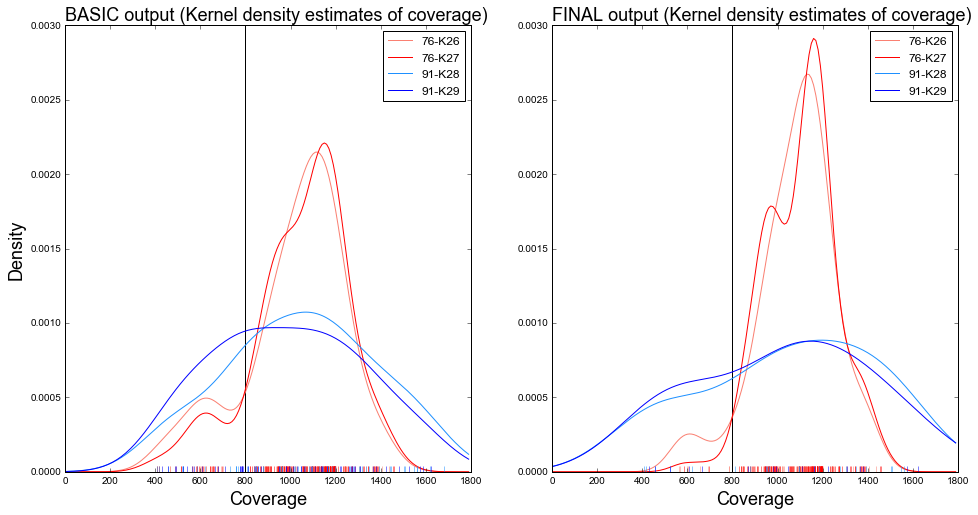

In [86]:
plt.figure(figsize=(16,8))
colors = ['salmon','red','dodgerblue','blue']

plt.subplot(121)
print('AUC up until coverage==800, PRE-FILTERING')
for ind,colony in enumerate(['76-K26', '76-K27', '91-K28', '91-K29']):
    bob = ss.kde.gaussian_kde(DF_COLONY.COVERAGE[(DF_COLONY.STAGE=='BASIC')&(DF_COLONY.COLONY==colony)])
    plt.plot(np.arange(0,1800,10), 
             bob.evaluate(np.arange(0,1800,10)),
             label=colony,
             color=colors[ind])
    plt.vlines(800,0,0.005)
    print(colony)
    print(bob.integrate_box_1d(0,800))
    print(np.mean(DF_COLONY.COVERAGE[(DF_COLONY.STAGE=='BASIC')&(DF_COLONY.COLONY==colony)]))
    
plt.legend()
plt.ylim(0,0.003)

for ind,colony in enumerate(['76-K26', '76-K27', '91-K28', '91-K29']):
    plt.plot(DF_COLONY.COVERAGE[(DF_COLONY.STAGE=='BASIC')&(DF_COLONY.COLONY==colony)],
             np.zeros(len(DF_COLONY.COVERAGE[(DF_COLONY.STAGE=='BASIC')&(DF_COLONY.COLONY==colony)]))+2e-5,
             '|', color=colors[ind])

plt.title('BASIC output (Kernel density estimates of coverage)', loc='left', size=18)    
plt.xlabel('Coverage', size=18)
plt.ylabel('Density', size=18)

plt.subplot(122)
print('AUC up until coverage==800, POST-FILTERING')
for ind,colony in enumerate(['76-K26', '76-K27', '91-K28', '91-K29']):
    bob = ss.kde.gaussian_kde(DF_COLONY.COVERAGE[(DF_COLONY.STAGE=='FINAL')&(DF_COLONY.COLONY==colony)])
    plt.plot(np.arange(0,1800,10), 
             bob.evaluate(np.arange(0,1800,10)),
             label=colony,
             color=colors[ind])
    plt.vlines(800,0,0.005)
    print(colony)
    print(bob.integrate_box_1d(0,800))
    print(np.mean(DF_COLONY.COVERAGE[(DF_COLONY.STAGE=='FINAL')&(DF_COLONY.COLONY==colony)]))
plt.legend()
plt.ylim(0,0.003)

for ind,colony in enumerate(['76-K26', '76-K27', '91-K28', '91-K29']):
    plt.plot(DF_COLONY.COVERAGE[(DF_COLONY.STAGE=='FINAL')&(DF_COLONY.COLONY==colony)],
             np.zeros(len(DF_COLONY.COVERAGE[(DF_COLONY.STAGE=='FINAL')&(DF_COLONY.COLONY==colony)]))+2e-5,
             '|', color=colors[ind])
plt.title('FINAL output (Kernel density estimates of coverage)', loc='left', size=18)
plt.xlabel('Coverage', size=18)

#NOW = datetime.datetime.now()
#TARGET = '../reports/figures/{}_colony_coverage.pdf'.format(NOW.strftime('%y%m%d'))
#plt.savefig(TARGET)

Something is weird about the 91 DNAs, look at the broader distribution of coverages. Why is this? Can cleary see the lower coverage bump that includes the 963XXX region I noticed above. Here I added an arbitrary 800-fold minimal coverage... basically the mean coverage is more or less the same for all (around 1050) so maybe a dynamic filter for this would be something that could be aproximated with 5% of a normal centered on the mean coverage? But this would not work for these broad distributions...

Let's look at what this cutoff would do to the colony SNP calls...

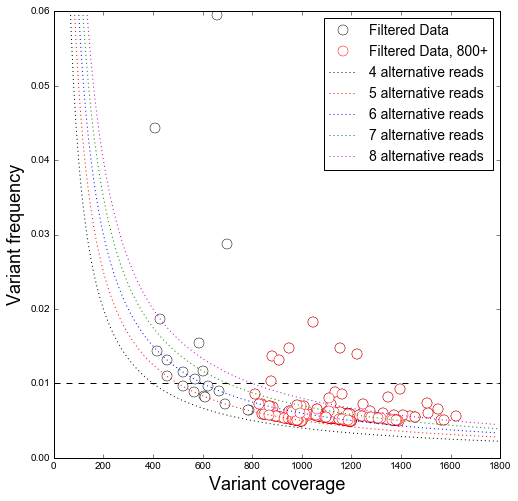

In [255]:
plt.figure(figsize=(8,8))
plt.plot(list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')].COVERAGE), 
         list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')].FREQUENCY), 
         'o', mfc='white', mec='black', ms=10, label='Filtered Data')

plt.plot(list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')&(DF_COLONY.COVERAGE>800)].COVERAGE), 
         list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')&(DF_COLONY.COVERAGE>800)].FREQUENCY), 
         'o', mfc='white', mec='red', ms=10, label='Filtered Data, 800+')

plt.plot(np.arange(0,1800,10), 
         4/np.arange(0,1800,10), 
         'k:', label='4 alternative reads')

plt.plot(np.arange(0,1800,10), 
         5/np.arange(0,1800,10), 
         'r:', label='5 alternative reads')

plt.plot(np.arange(0,1800,10), 
         6/np.arange(0,1800,10), 
         'b:', label='6 alternative reads')

plt.plot(np.arange(0,1800,10), 
         7/np.arange(0,1800,10), 
         'g:', label='7 alternative reads')

plt.plot(np.arange(0,1800,10), 
         8/np.arange(0,1800,10), 
         'm:', label='8 alternative reads')

plt.legend(loc=0, fontsize=14)
plt.ylabel('Variant frequency', size=18)
plt.xlabel('Variant coverage', size=18)
plt.xlim(0,1800)
#plt.yscale('log')
plt.ylim(0,0.06)
plt.hlines(0.01,0,1800, linestyles='dashed')

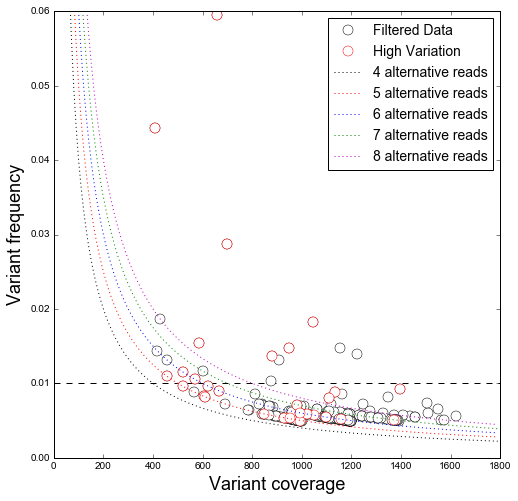

In [32]:
plt.figure(figsize=(8,8))
plt.plot(list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')].COVERAGE), 
         list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')].FREQUENCY), 
         'o', mfc='white', mec='black', ms=10, label='Filtered Data')

plt.plot(list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')&(DF_COLONY.HIGH_VARIATION==1)].COVERAGE), 
         list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')&(DF_COLONY.HIGH_VARIATION==1)].FREQUENCY), 
         'o', mfc='white', mec='red', ms=10, label='High Variation')

plt.plot(np.arange(0,1800,10), 
         4/np.arange(0,1800,10), 
         'k:', label='4 alternative reads')

plt.plot(np.arange(0,1800,10), 
         5/np.arange(0,1800,10), 
         'r:', label='5 alternative reads')

plt.plot(np.arange(0,1800,10), 
         6/np.arange(0,1800,10), 
         'b:', label='6 alternative reads')

plt.plot(np.arange(0,1800,10), 
         7/np.arange(0,1800,10), 
         'g:', label='7 alternative reads')

plt.plot(np.arange(0,1800,10), 
         8/np.arange(0,1800,10), 
         'm:', label='8 alternative reads')

plt.legend(loc=0, fontsize=14)
plt.ylabel('Variant frequency', size=18)
plt.xlabel('Variant coverage', size=18)
plt.xlim(0,1800)
#plt.yscale('log')
plt.ylim(0,0.06)
plt.hlines(0.01,0,1800, linestyles='dashed')

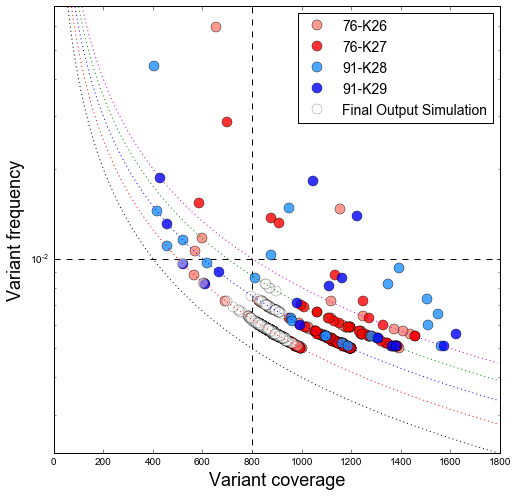

In [84]:
plt.figure(figsize=(8,8))

colors = ['salmon','red','dodgerblue','blue']
for ind,colony in enumerate(['76-K26', '76-K27', '91-K28', '91-K29']):
    plt.plot(list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')&(DF_COLONY.COLONY==colony)].COVERAGE), 
             list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')&(DF_COLONY.COLONY==colony)].FREQUENCY), 
             'o', color=colors[ind], ms=10, label=colony, alpha=0.8)
    
plt.plot(list(DF_ART[(DF_ART.STAGE=='FINAL')].COVERAGE), 
         list(DF_ART[(DF_ART.STAGE=='FINAL')].FREQUENCY), 
         'o', mfc='white', mec='black', ms=10, label='Final Output Simulation',alpha=0.4)

plt.plot(np.arange(0,1800,10), 
         4/np.arange(0,1800,10), 
         'k:')

plt.plot(np.arange(0,1800,10), 
         5/np.arange(0,1800,10), 
         'r:')

plt.plot(np.arange(0,1800,10), 
         6/np.arange(0,1800,10), 
         'b:')

plt.plot(np.arange(0,1800,10), 
         7/np.arange(0,1800,10), 
         'g:')

plt.plot(np.arange(0,1800,10), 
         8/np.arange(0,1800,10), 
         'm:')

plt.legend(loc=0, fontsize=14)
plt.ylabel('Variant frequency', size=18)
plt.xlabel('Variant coverage', size=18)
plt.xlim(0,1800)
plt.yscale('log')
plt.ylim(0,0.07)
plt.hlines(0.01,0,1800, linestyles='dashed')
plt.vlines(800,0,0.1, linestyles='dashed')

#NOW = datetime.datetime.now()
#TARGET = '../reports/figures/{}_SNPcoverage_colony.pdf'.format(NOW.strftime('%y%m%d'))
#plt.savefig(TARGET)

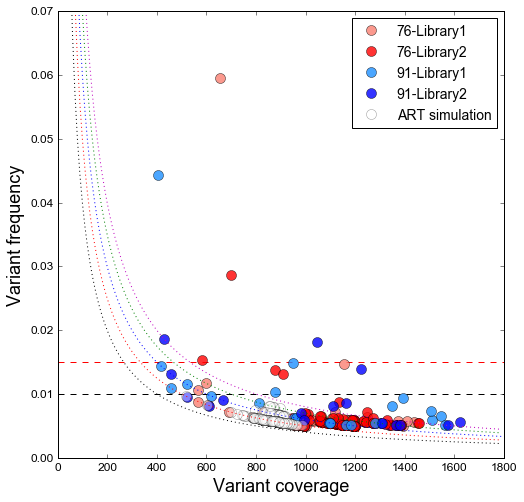

In [10]:
plt.figure(figsize=(8,8))

colors = ['salmon','red','dodgerblue','blue']
labels = ['76-Library1', '76-Library2', '91-Library1', '91-Library2']
for ind,colony in enumerate(['76-K26', '76-K27', '91-K28', '91-K29']):
    plt.plot(list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')&(DF_COLONY.COLONY==colony)].COVERAGE), 
             list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')&(DF_COLONY.COLONY==colony)].FREQUENCY), 
             'o', color=colors[ind], ms=10, label=labels[ind], alpha=0.8)
    
plt.plot(list(DF_ART[(DF_ART.STAGE=='FINAL')].COVERAGE), 
         list(DF_ART[(DF_ART.STAGE=='FINAL')].FREQUENCY), 
         'o', mfc='white', mec='black', ms=10, label='ART simulation',alpha=0.4)

plt.plot(np.arange(0,1800,10), 
         4/np.arange(0,1800,10), 
         'k:')

plt.plot(np.arange(0,1800,10), 
         5/np.arange(0,1800,10), 
         'r:')

plt.plot(np.arange(0,1800,10), 
         6/np.arange(0,1800,10), 
         'b:')

plt.plot(np.arange(0,1800,10), 
         7/np.arange(0,1800,10), 
         'g:')

plt.plot(np.arange(0,1800,10), 
         8/np.arange(0,1800,10), 
         'm:')

plt.legend(loc=0, fontsize=14)
plt.ylabel('Variant frequency', size=18)
plt.xlabel('Variant coverage', size=18)
plt.xlim(0,1800)
#plt.yscale('log')
plt.ylim(0,0.07)
plt.hlines(0.01,0,1800, linestyles='dashed')
plt.hlines(0.015,0,1800, linestyles='dashed', colors='red')
plt.yticks(size=12)
plt.xticks(size=12)


#plt.savefig('../reports/figures/1_single_colony_FreqCov.pdf')
#plt.savefig('../reports/figures/1_single_colony_FreqCov.png',dpi=300)

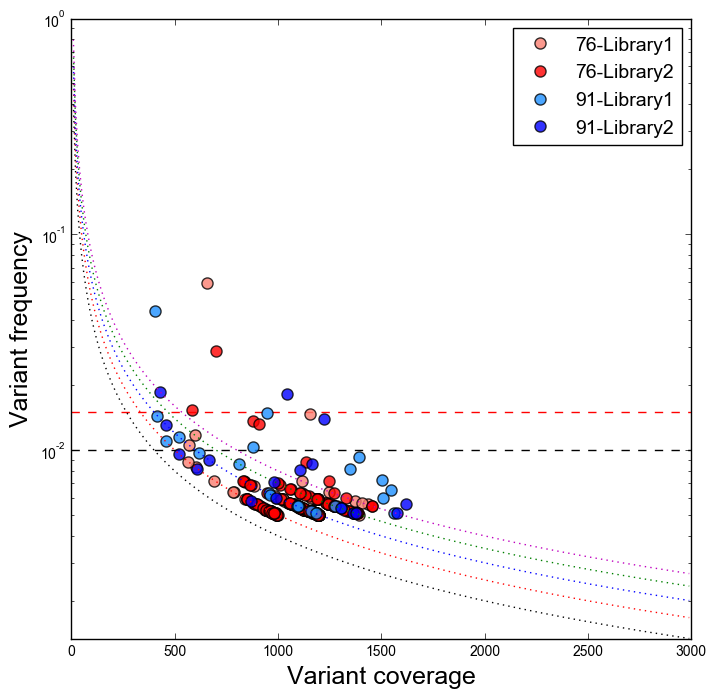

In [16]:
tick_size = 10
label_size = 18
title_size = 24
text_size = 14

plt.figure(figsize=(8,8))

colors = ['salmon','red','dodgerblue','blue']
labels = ['76-Library1', '76-Library2', '91-Library1', '91-Library2']
for ind,colony in enumerate(['76-K26', '76-K27', '91-K28', '91-K29']):
    plt.plot(list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')&(DF_COLONY.COLONY==colony)].COVERAGE), 
             list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')&(DF_COLONY.COLONY==colony)].FREQUENCY), 
             'o', color=colors[ind], ms=8, mew=1, label=labels[ind], alpha=0.8)

plt.legend(loc=0, fontsize=text_size)

plt.plot(np.arange(0,3000,10), 
         4/np.arange(0,3000,10), 
         'k:', label='4 alternative reads')

plt.plot(np.arange(0,3000,10), 
         5/np.arange(0,3000,10), 
         'r:', label='5 alternative reads')

plt.plot(np.arange(0,3000,10), 
         6/np.arange(0,3000,10), 
         'b:', label='6 alternative reads')

plt.plot(np.arange(0,3000,10), 
         7/np.arange(0,3000,10), 
         'g:', label='7 alternative reads')

plt.plot(np.arange(0,3000,10), 
         8/np.arange(0,3000,10), 
         'm:', label='8 alternative reads')

plt.ylabel('Variant frequency', size=label_size)
plt.xlabel('Variant coverage', size=label_size)
plt.xlim(0,3000)
plt.yscale('log')
plt.ylim(0,1)
plt.hlines(0.01,0,3000, linestyles='dashed')
plt.hlines(0.015,0,3000, linestyles='dashed', colors='red')
plt.yticks(size=tick_size)
plt.xticks(size=tick_size)


plt.savefig('../reports/figures/1_single_colony_FreqCov.pdf')
plt.savefig('../reports/figures/1_single_colony_FreqCov.png',dpi=300)

In [340]:
DF_COLONY[(DF_COLONY.STAGE=='FINAL')&(DF_COLONY.COVERAGE>800)&(DF_COLONY.FREQUENCY>0.01)]

,ALT_BASE,COLONY,COVERAGE,FREQUENCY,LOCUS,REF_BASE,STAGE,HIGH_VARIATION
67,A,76-K26,1155,0.0147,2827052,C,FINAL,0
308,A,76-K27,878,0.0137,1441540,G,FINAL,1
377,G,76-K27,908,0.0132,3587184,A,FINAL,0
579,T,91-K28,949,0.0148,1441574,A,FINAL,1
588,C,91-K28,877,0.0103,4355979,A,FINAL,0
656,T,91-K29,1045,0.0182,1441546,G,FINAL,1
660,A,91-K29,1223,0.0139,3114195,C,FINAL,0


Three of these are within 34 nucleotides of each other. Manual annotation 1441540 (synonymous, A66A), 1441546 (synonymous, A68A, essentially the same as A66A...) and 1441574 (nonsynonymous, N77Y). So this makes it unlikely to be real, again a mapping issue?

In [267]:
print(Counter(DF_COLONY[(DF_COLONY.STAGE=='BASIC')].COLONY))
print(Counter(DF_COLONY[(DF_COLONY.STAGE=='FINAL')].COLONY))

Counter({'76-K27': 167, '76-K26': 152, '91-K28': 59, '91-K29': 53})
Counter({'76-K27': 133, '76-K26': 116, '91-K28': 22, '91-K29': 17})


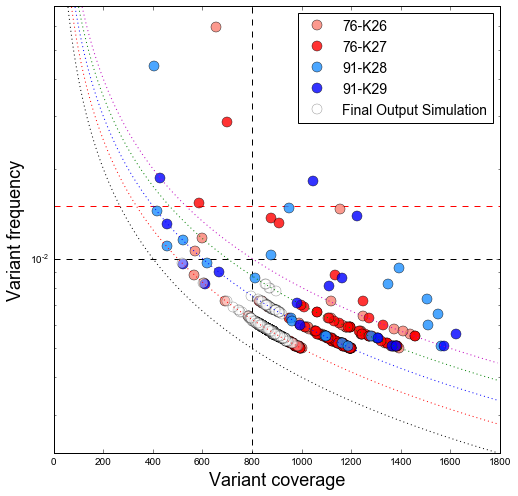

In [85]:
plt.figure(figsize=(8,8))

colors = ['salmon','red','dodgerblue','blue']
for ind,colony in enumerate(['76-K26', '76-K27', '91-K28', '91-K29']):
    plt.plot(list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')&(DF_COLONY.COLONY==colony)].COVERAGE), 
             list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')&(DF_COLONY.COLONY==colony)].FREQUENCY), 
             'o', color=colors[ind], ms=10, label=colony, alpha=0.8)
    
plt.plot(list(DF_ART[(DF_ART.STAGE=='FINAL')].COVERAGE), 
         list(DF_ART[(DF_ART.STAGE=='FINAL')].FREQUENCY), 
         'o', mfc='white', mec='black', ms=10, label='Final Output Simulation',alpha=0.4)

plt.plot(np.arange(0,1800,10), 
         4/np.arange(0,1800,10), 
         'k:')

plt.plot(np.arange(0,1800,10), 
         5/np.arange(0,1800,10), 
         'r:')

plt.plot(np.arange(0,1800,10), 
         6/np.arange(0,1800,10), 
         'b:')

plt.plot(np.arange(0,1800,10), 
         7/np.arange(0,1800,10), 
         'g:')

plt.plot(np.arange(0,1800,10), 
         8/np.arange(0,1800,10), 
         'm:')

plt.legend(loc=0, fontsize=14)
plt.ylabel('Variant frequency', size=18)
plt.xlabel('Variant coverage', size=18)
plt.xlim(0,1800)
plt.yscale('log')
plt.ylim(0,0.07)
plt.hlines(0.01,0,1800, linestyles='dashed')
plt.hlines(0.015,0,1800, linestyles='dashed', colors='red')
plt.vlines(800,0,0.1, linestyles='dashed')

#NOW = datetime.datetime.now()
#TARGET = '../reports/figures/{}_SNPcoverage_colony.pdf'.format(NOW.strftime('%y%m%d'))
#plt.savefig(TARGET)

Placing a 1.5% cutoff together with a 800 minimum coverage seems to work well enough to exclude all but one SNP (the nonsynonymous SNP at 1441574...). Looking at the distribution of these SNPs its plenty apparent that there is more going on here than with the simulations. 

So we can argue that:
1. up to 1% we have sequencing issues,
2. between 1-1.5% we have additional culture issues,
3. Introducing a high minimal coverage can improve the signal by filtering out additional trouble regions in the genome.

## Patient data
Applying a 1.5% frequency threshold to patient data...

In [2]:
PATIENTS_FINAL = pd.read_csv('../data/interim/1_FINAL.csv', index_col=0)


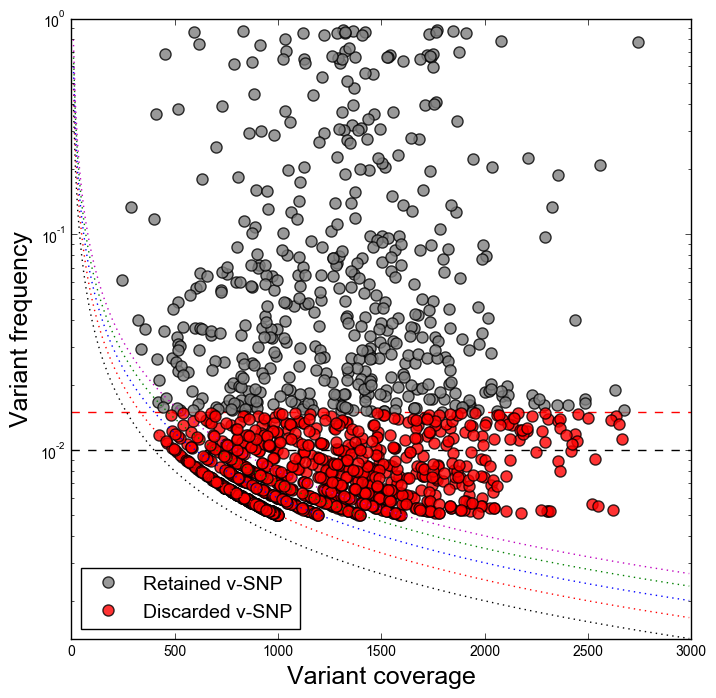

In [13]:
tick_size = 8
label_size = 18
title_size = 12
text_size = 14

plt.figure(figsize=(8,8))

plt.plot(list(PATIENTS_FINAL[(PATIENTS_FINAL.FREQUENCY>=0.015)].COVERAGE), 
         list(PATIENTS_FINAL[(PATIENTS_FINAL.FREQUENCY>=0.015)].FREQUENCY), 
         'o', mew=1, mec='black', mfc='grey', ms=8, label='Retained v-SNP', alpha=0.8)
    
plt.plot(list(PATIENTS_FINAL[(PATIENTS_FINAL.FREQUENCY<0.015)].COVERAGE), 
         list(PATIENTS_FINAL[(PATIENTS_FINAL.FREQUENCY<0.015)].FREQUENCY), 
         'o', mew=1, mec='black', mfc='red', ms=8, label='Discarded v-SNP', alpha=0.8)

plt.plot(np.arange(0,3000,10), 
         4/np.arange(0,3000,10), 
         'k:')

plt.plot(np.arange(0,3000,10), 
         5/np.arange(0,3000,10), 
         'r:')

plt.plot(np.arange(0,3000,10), 
         6/np.arange(0,3000,10), 
         'b:')

plt.plot(np.arange(0,3000,10), 
         7/np.arange(0,3000,10), 
         'g:')

plt.plot(np.arange(0,3000,10), 
         8/np.arange(0,3000,10), 
         'm:')

plt.legend(loc=0, fontsize=text_size)
plt.ylabel('Variant frequency', size=label_size)
plt.xlabel('Variant coverage', size=label_size)
plt.xlim(0,3000)
plt.yscale('log')
plt.ylim(0,1)
plt.hlines(0.01,0,3000, linestyles='dashed')
plt.hlines(0.015,0,3000, linestyles='dashed', colors='red')

plt.savefig('../reports/figures/1_vSNP_FreqCov.pdf')
plt.savefig('../reports/figures/1_vSNP_FreqCov.png',dpi=300)